# Medical Image Classification for Pneumonia
##2. Pytorch with custom CNN

## Dataset

In [1]:
# Setting Directory
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from PIL import Image
from torch import optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import cv2

In [3]:
# Load Dataset
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/ChestXRay2017.zip"

replace chest_xray/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
# Count the number of images
from glob import glob

filepaths_train_normal = list(glob('/content/chest_xray/train/NORMAL/*.jpeg'))
filepaths_test_normal = list(glob('/content/chest_xray/test/NORMAL/*.jpeg'))
filepaths_train_pneumonia = list(glob('/content/chest_xray/train/PNEUMONIA/*.jpeg'))
filepaths_test_pneumonia = list(glob('/content/chest_xray/test/PNEUMONIA/*.jpeg'))
print("Number of Normal:", (len(filepaths_train_normal)+len(filepaths_test_normal)))
print("Number of Pneumonia:", (len(filepaths_train_pneumonia)+len(filepaths_test_pneumonia)))

Number of Normal: 1583
Number of Pneumonia: 4273


In [25]:
def load_data(path):
  defaultTF = transforms.Compose([transforms.ToTensor(),
                                  transforms.Resize((64,64)),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ])
  customTF = transforms.Compose([transforms.ToTensor(),
                                 transforms.Resize((64,64)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomAffine(degrees=(-30,30)),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])
  train_dataset = torchvision.datasets.ImageFolder(root=path+"/train", transform=customTF)
  test_dataset = torchvision.datasets.ImageFolder(root=path+"/test", transform=defaultTF)

  return train_dataset, test_dataset

In [26]:
train_dataset, test_dataset = load_data('/content/chest_xray')
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

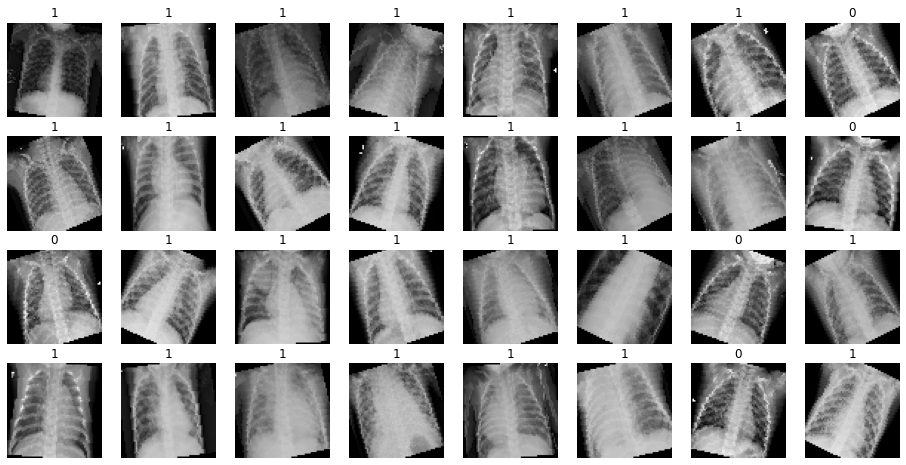

In [27]:
# See Images
def convert_to_imshow_format(image):
    image = image / 2 + 0.5       # Convert range from [-1, 1] to [0,1]
    image = image.numpy()
    return image.transpose(1,2,0) # Convert from CHW to HWC

images, labels = next(iter(train_dataloader))
images = images[:32]
labels = labels[:32]

plt.figure(figsize=(16, 8))
for i, img in enumerate(images):
    plt.subplot(4, 8, i+1)
    plt.title(int(labels[i]))
    plt.axis('off')
    plt.imshow(convert_to_imshow_format(img))

## CNN Model

In [28]:
class customCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5),
                              nn.ReLU(),
                              nn.MaxPool2d(2,2),
                              nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
                              nn.ReLU(),
                              nn.MaxPool2d(4,4),
                              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
                              nn.ReLU(),
                              nn.MaxPool2d(2,2),
                              nn.Flatten(),
                              nn.Linear(64,128),
                              nn.ReLU(),
                              nn.Dropout(0.2),
                              nn.Linear(128,2),
                              nn.ReLU())

  def forward(self, x):
    x = self.conv(x)
    return x    

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = customCNN().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [31]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        predictions = model(X)
        loss = loss_fn(predictions, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (predictions.argmax(1)==y).sum().item()

    train_loss /= num_batches
    train_acc /= size

    print(f"Train Error: Accuracy: {(100*train_acc):>0.1f}%, Avg loss: {train_loss:>8f}")

    return train_loss, train_acc



def test(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            predictions = model(X)
            test_loss += loss_fn(predictions, y).item()
            test_acc += (predictions.argmax(1) == y).sum().item()

    test_loss /= num_batches
    test_acc /= size

    print(f"Test Error: Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f}\n")

    return test_loss, test_acc

In [32]:
# Train and evaluate the model
train_losses, train_accs, test_losses, test_accs = [],[],[],[]

for t in range(5):
    print(f"Epoch {t+1}-------------------------------")
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(test_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

Epoch 1-------------------------------
Train Error: Accuracy: 80.9%, Avg loss: 0.434637
Test Error: Accuracy: 83.2%, Avg loss: 0.354199

Epoch 2-------------------------------
Train Error: Accuracy: 89.6%, Avg loss: 0.251367
Test Error: Accuracy: 84.1%, Avg loss: 0.384617

Epoch 3-------------------------------
Train Error: Accuracy: 92.7%, Avg loss: 0.184792
Test Error: Accuracy: 77.6%, Avg loss: 0.691363

Epoch 4-------------------------------
Train Error: Accuracy: 94.1%, Avg loss: 0.145689
Test Error: Accuracy: 77.7%, Avg loss: 0.698603

Epoch 5-------------------------------
Train Error: Accuracy: 95.3%, Avg loss: 0.128614
Test Error: Accuracy: 84.0%, Avg loss: 0.467636



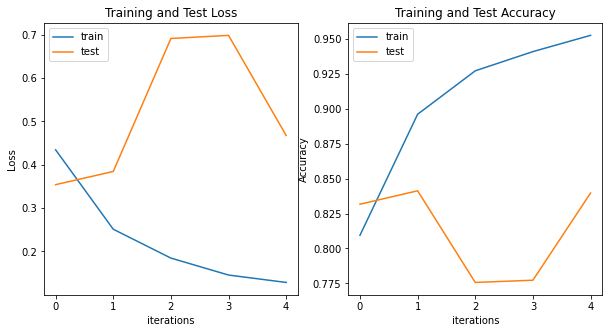

In [33]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title("Training and Test Loss")
plt.plot(train_losses,label="train")
plt.plot(test_losses,label="test")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
plt.title("Training and Test Accuracy")
plt.plot(train_accs, label = "train")
plt.plot(test_accs, label="test")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()

plt.show()